In [1]:
import matplotlib.pyplot as plt
# import simpreglib as srl
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

plt.style.use('fivethirtyeight')

In [2]:
df1=pd.read_csv('data/cleaned_kc.csv')
df2=pd.read_csv('data/kc_house_data.csv')
dfo = df2[['price','grade','sqft_living','sqft_lot','bedrooms','bathrooms']]
df1.drop('waterfront_loc',axis=1,inplace=True)

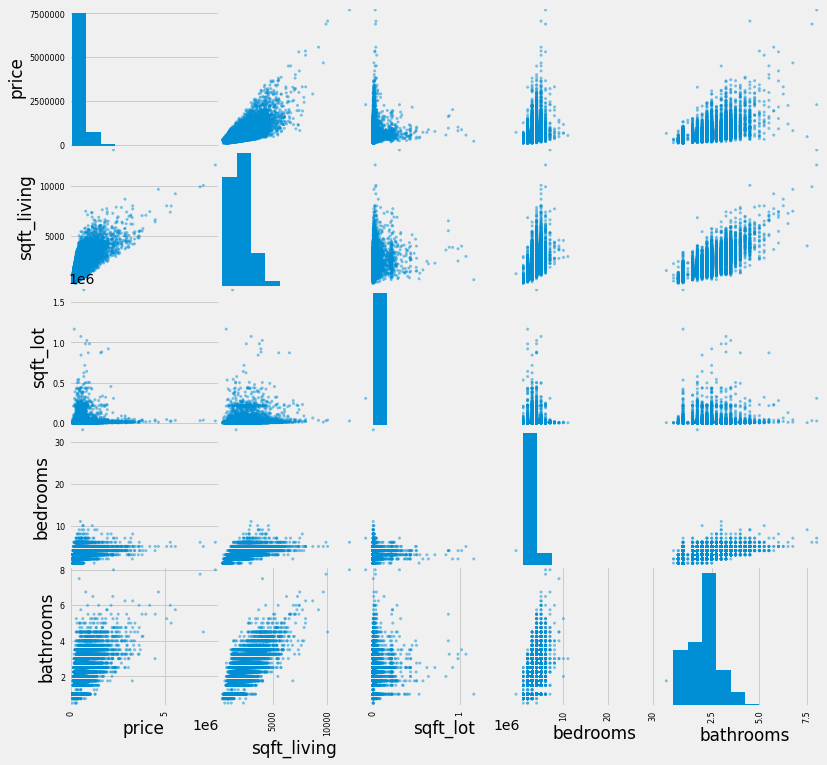

In [3]:
pd.plotting.scatter_matrix(dfo,figsize=(12,12))
plt.show()

In [ ]:
pd.plotting.scatter_matrix(df1,figsize=(12,12))
plt.tight_layout()
plt.show()

#### Simple linear regression on select features
Assumtion check: 
- is it linear?
- is it normal?
    - histogram
    - Q-Q plot
- is it homoscedastic?

##### For engineered features . . .

In [ ]:
# visualize the relationship between the predictors and the target using scatterplots
fig, axs = plt.subplots(1, 5,sharey=True, figsize=(18, 6))
labels = df1.columns[1:]
for idx, channel in enumerate(labels):
    df1.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
    
plt.legend()
plt.show()

In [ ]:
# # For all the variables, check distribution by creating a histogram with kde
for column in df1 :
    df1[column].plot.hist(density=True,label = column+' histogram')
    df1[column].plot.kde(label = column+' kde')
    plt.legend()
    plt.show()

In [ ]:
outcome = 'price'
x_cols =  ['day_of_year', 'relative_living_space', 'relative_lot_size','bed_bath_ratio', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df1).fit()
model.summary()

In [ ]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

The plots above show relative living space, and grade to be the most promising

In [4]:
# non_normal = list(df1.columns[1:])

# # log transform data frame
# for feat in non_normal: 
#     df1[feat] = df1[feat].map(lambda x: np.log(x))
#     df1.loc[df1[feat].isnull()] = 0

#  # deal with valuable zeros
# for feat in ['relative_living_space','relative_lot_size']:
#     df1[feat] = df1[feat].fillna(0)

#  # deal with -inf values
# for label in df1.columns: # deal with -inf values
#     df1.drop(df1.index[df1[label] == np.NINF], inplace=True)


In [ ]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

In [ ]:
outcome = 'price'
x_cols =  ['day_of_year', 'relative_living_space', 'relative_lot_size','bed_bath_ratio', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df1).fit()
model.summary()

In [ ]:
# fspace = 'price~relative_living_space'
# fsize = 'price~relative_lot_size'
# fgrade = 'price~grade'
# fday = 'price~day_of_year'
# fbb = 'price~bed_bath_ratio'

# space_model = smf.ols(formula=fspace, data=df1).fit()
# size_model = smf.ols(formula=fsize, data=df1).fit()
# grade_model = smf.ols(formula=fgrade, data=df1).fit()
# day_model = smf.ols(formula=fday, data=df1).fit()
# fbb_model = smf.ols(formula=fbb, data=df1).fit()

In [ ]:
# print(space_model.pvalues)
# space_model.summary()